> 11/29更新

<h1> 自己相互情報量PMIに基づく極性付与


議事録を「利下げ」「維持」「利上げ」の三つのグループ（トピック）に分けそれぞれの議事録で使用された単語の出現頻度を基に自己相互情報量PMIを計算し、単語ごとに極性辞書を作成.

$$ PMI(w,t) = \log_2 \frac{P(w,t)}{P(w)P(t)} $$
- $P(w,t)$：単語wとトピックtが同時に出現する確率
- $P(w)$：コーパス中の単語wの出現確率
- $P(t)$：議事録中のトピックtの出現確率


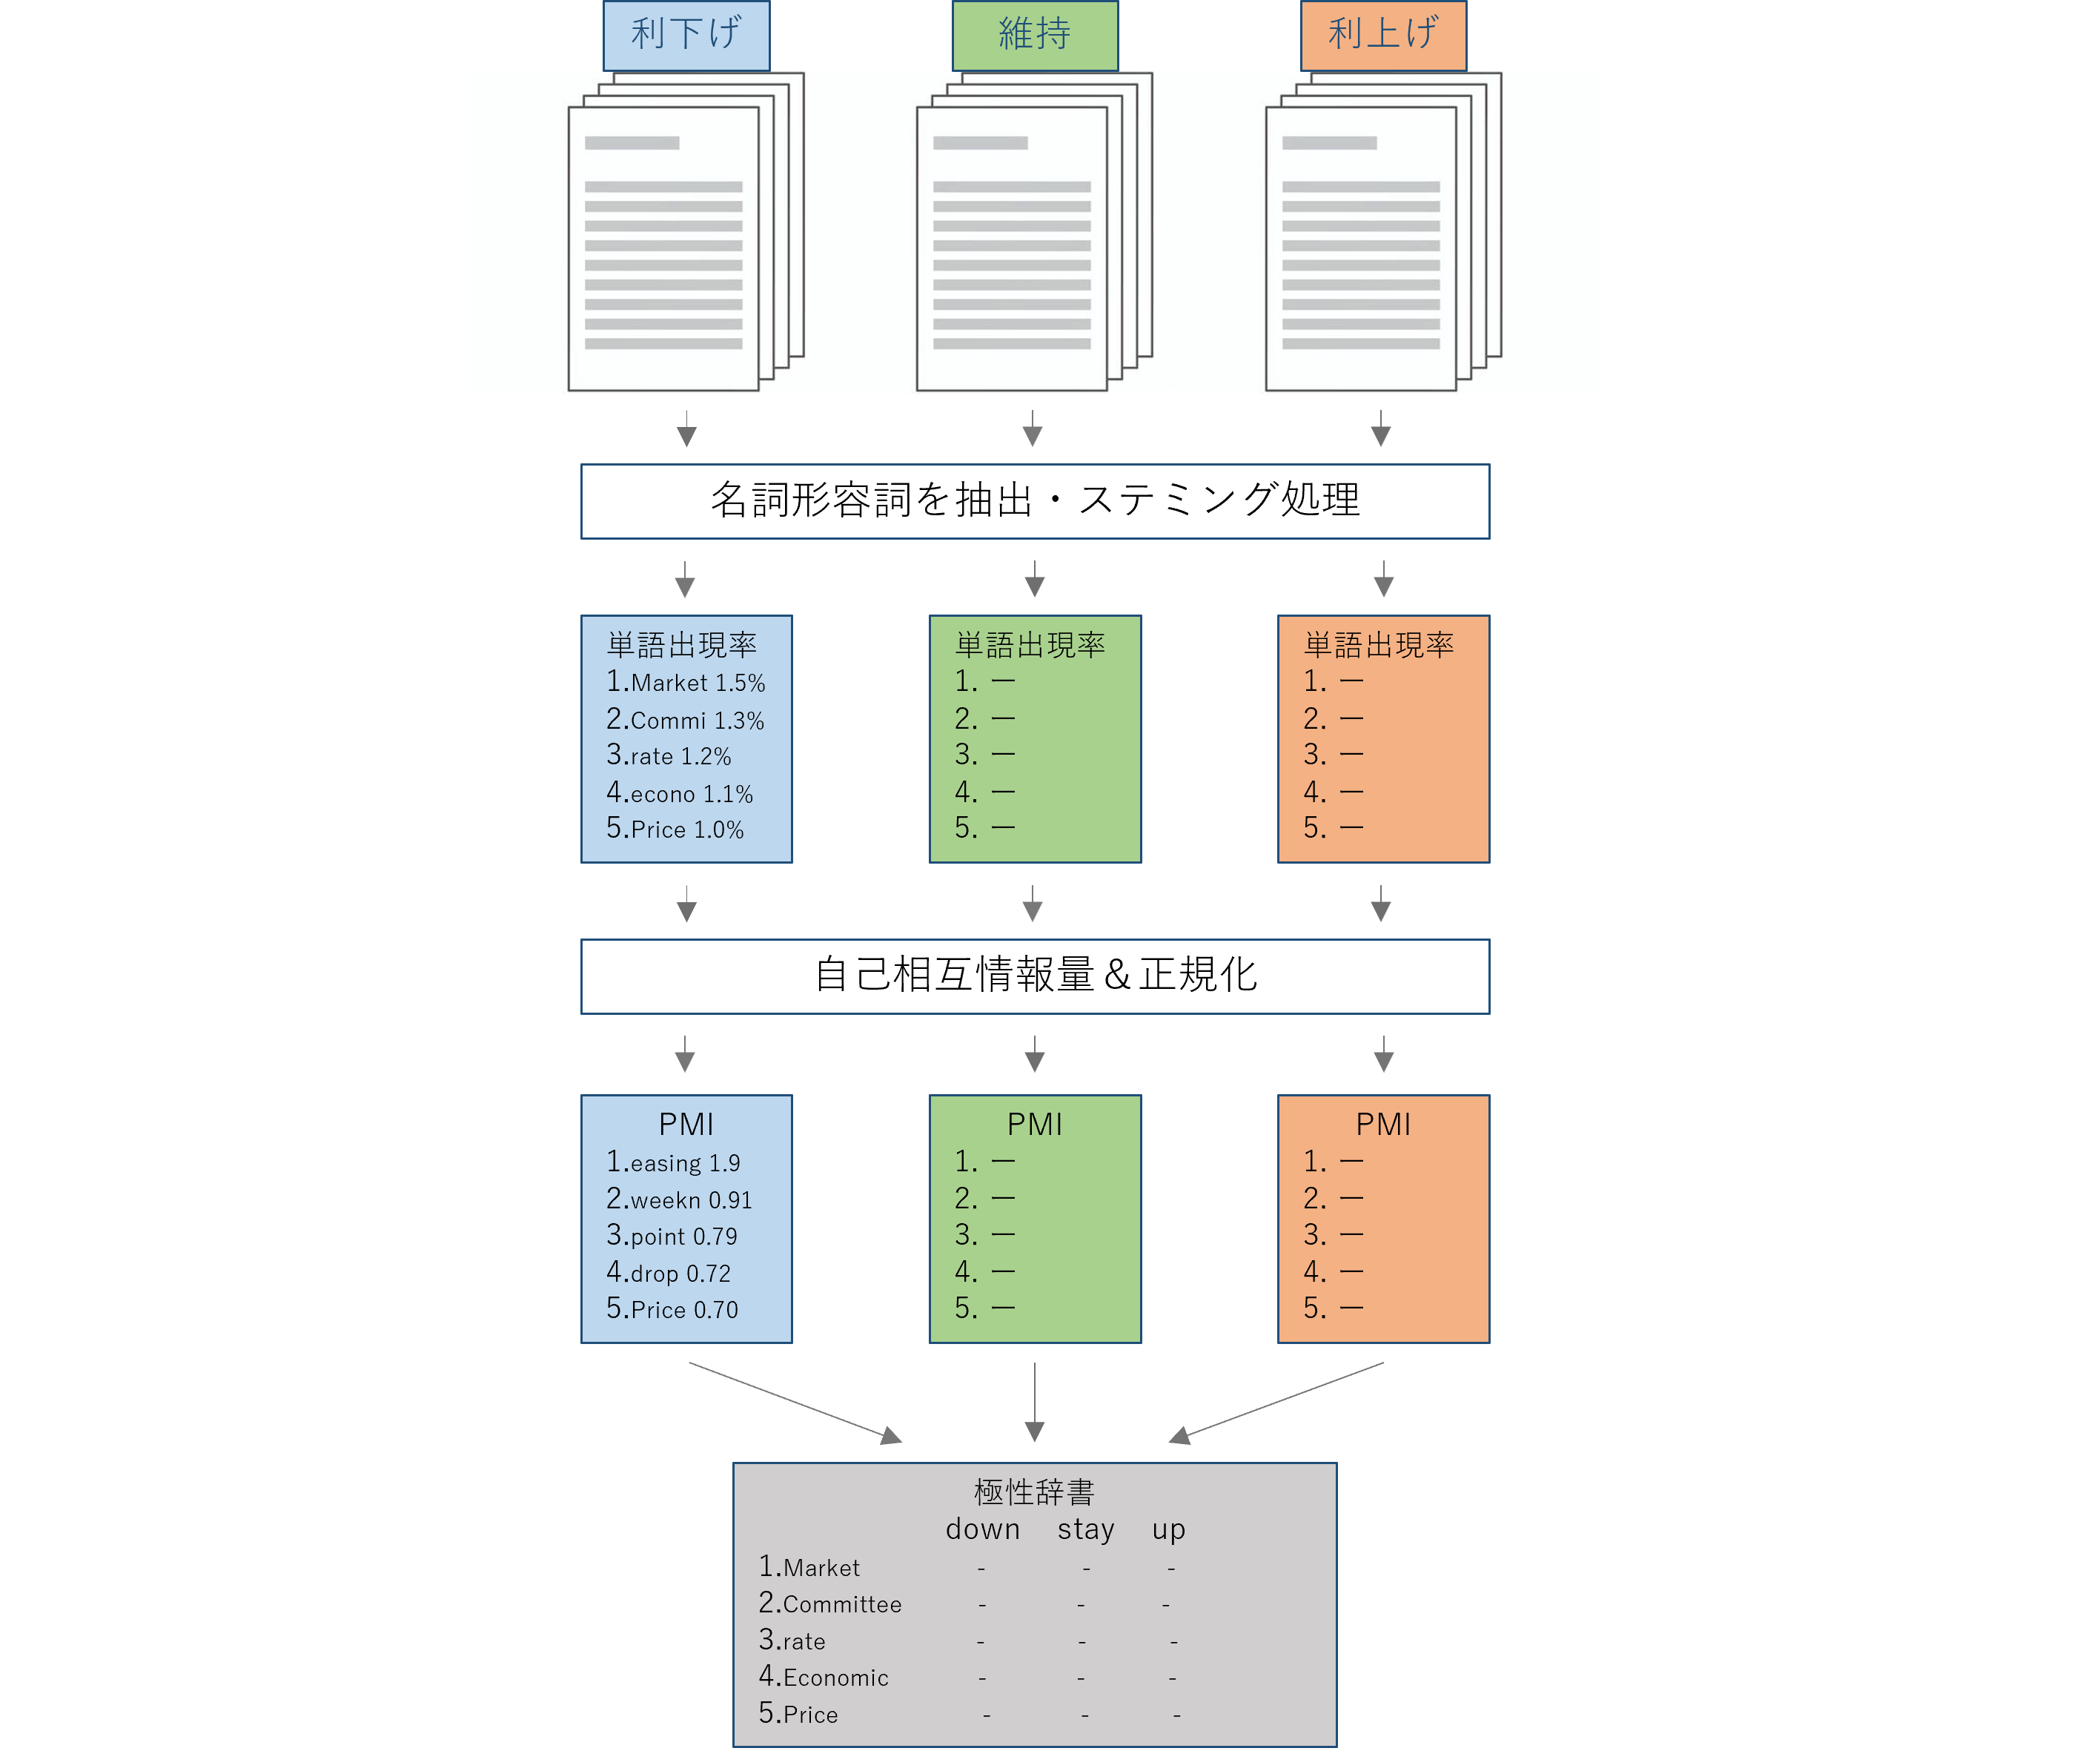

<h1> PMIに基づく文書ベクトル

文書ベクトル＝文書に含まれる単語のPMI値の平均値

$$ D_t = \frac{1}{N} \sum_{s=1}^{S=N} PMI(w_s, t) $$

$$ t \in \{raise, hold, lower \}$$
$$ N:文書Dに含まれる単語数 $$


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#1 データの読み込み

>下記のデータを読み込む
- 議事録のドキュメントファイル
- 政策金利データ

> 1994/2 ～ 2021/9までのFOMC議事録

In [2]:
import glob, os
import numpy as np
import pandas as pd


#議事録のドキュメントファイルを読み込む
files = glob.glob('/content/drive/MyDrive/datas/FOMC_text_data/*.txt')

files.sort()
txt_datas = [open(file, "r").read() for file in files]
filenames = [os.path.splitext(os.path.basename(file))[0] for file in files] #パス名からファイル名(日付)のみを取得（str）
documents_date = np.array([int(name) for name in filenames])
doc_info = pd.DataFrame({'Document' : txt_datas}, index = documents_date)
doc_info

,Document
199402,The Federal Reserve Board eagle logo links to ...
199403,The Federal Reserve Board eagle logo links to ...
199405,The Federal Reserve Board eagle logo links to ...
199407,The Federal Reserve Board eagle logo links to ...
199408,The Federal Reserve Board eagle logo links to ...
...,...
202103,A joint meeting of the Federal Open Market Com...
202104,A joint meeting of the Federal Open Market Com...
202106,A joint meeting of the Federal Open Market Com...
202107,A joint meeting of the Federal Open Market Com...


> 1982/9 ～ 2021/9までの政策金利データ

In [3]:
#日付を６桁の数値にする関数(2021-5-27→202105)
def str_6(datetime):
  date_6 = [int(str(date.year)+str(date.month).zfill(2)) for date in datetime]
  return date_6
  
#金利の変化の情報を読み込む
target_info = pd.read_excel('/content/drive/MyDrive/datas/target/FF_rate_change.xlsx', header=2, usecols=[0,1,2,3,4,5,6,7,8])#精度向上したLSTM
target_info.index = str_6(target_info['Date']) #日付変換
target_info.drop(columns='Date', inplace=True) #日付の列削除

target_info

,会合の有無,FF_Target,前月からの変化幅,当月の変化,一か月前ずらし,前会合からの差,当会合の変化,１会合前ずらし
198209,●,10.250,-,-,1,-,-,1
198210,NaN,9.500,-0.75,1,1,NaN,NaN,NaN
198211,●,9.000,-0.5,1,1,-1.25,1,1
198212,●,8.500,-0.5,1,0,-0.5,1,0
198301,●,8.500,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...
202105,NaN,0.125,0,0,0,NaN,NaN,NaN
202106,●,0.125,0,0,0,0,0,0
202107,NaN,0.125,0,0,0,NaN,NaN,NaN
202108,NaN,0.125,0,0,0,NaN,NaN,NaN


> 議事録と政策金利の時系列をそろえる

In [4]:
#議事録と教師データの関係
doc_info['FF_Target'] = target_info['FF_Target']
doc_info['当月の変化'] = target_info['当月の変化']
doc_info['一か月前ずらし'] = doc_info['当月の変化'].shift(-1) #議事録ごとの時系列にした後にシフト

pd.set_option('display.max_rows',10)
doc_info

,Document,FF_Target,当月の変化,一か月前ずらし
199402,The Federal Reserve Board eagle logo links to ...,3.250,2,2
199403,The Federal Reserve Board eagle logo links to ...,3.500,2,2
199405,The Federal Reserve Board eagle logo links to ...,4.250,2,0
199407,The Federal Reserve Board eagle logo links to ...,4.250,0,2
199408,The Federal Reserve Board eagle logo links to ...,4.750,2,0
...,...,...,...,...
202103,A joint meeting of the Federal Open Market Com...,0.125,0,0
202104,A joint meeting of the Federal Open Market Com...,0.125,0,0
202106,A joint meeting of the Federal Open Market Com...,0.125,0,0
202107,A joint meeting of the Federal Open Market Com...,0.125,0,0


#2 文書の前処理

##2.1. ステミング処理

> 名詞と形容詞のみ抽出する

In [5]:
import nltk
nltk.download('punkt') #word_tokenizeに使用
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet') #stemmerに使用

#名詞・形容詞を抽出する関数を作成
def extract_NNJJ(text):
  text = text.lower()#
  morph = nltk.word_tokenize(text)
  pos = nltk.pos_tag(morph)
  NN_JJ = [x[0] for i,x in enumerate(pos) if x[1] in ['NN','NNS','NNP','JJ','JJR','FFS']] #名詞と形容詞のみ取得
  stemmer = [nltk.stem.WordNetLemmatizer().lemmatize(word) for word in NN_JJ] #ステミング

  return stemmer

text_onlyNNJJ = [extract_NNJJ(text) for text in txt_datas] #議事録から名詞と形容詞を取得

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


##2.2. 出現頻度のカウント

> 文書ごとに、含まれる単語数をカウント

In [6]:
def makeWordMatrix(text_NNJJ):
  #単語のサンプル数だけidを作成
  words = [word for text in text_NNJJ for word in text]

  word_to_id = {}
  id_to_word = {}
  for word in words:
    if word not in word_to_id:
      new_id = len(word_to_id)
      word_to_id[word] = new_id
      id_to_word[new_id] = word

  #print('word_id')
  #print(word_to_id)
  #print('-'*50)
  #print('input_text')
  #print(text_NNJJ)

  #単語文書行列Mを作成
  M = np.zeros((len(word_to_id), len(text_NNJJ)))
  for j, text in enumerate(text_NNJJ):
    for word in text:
      M[word_to_id[word], j] += 1
  return M, word_to_id, id_to_word


M, word_to_id, id_to_word = makeWordMatrix(text_onlyNNJJ)
info = pd.DataFrame(M, index=[word for word in word_to_id], columns=documents_date)
info['sum'] = info.sum(axis='columns')
info = info.sort_values('sum', ascending=False)

print('単語文書行列')
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns',10)
info.drop('sum')

単語文書行列


,199402,199403,199405,199407,199408,...,202104,202106,202107,202109,sum
market,83.0,51.0,32.0,40.0,32.0,...,74.0,75.0,74.0,65.0,12250.0
committee,105.0,48.0,30.0,61.0,30.0,...,44.0,46.0,86.0,47.0,11235.0
rate,37.0,31.0,33.0,42.0,30.0,...,48.0,75.0,64.0,52.0,10119.0
federal,75.0,22.0,18.0,18.0,23.0,...,52.0,60.0,55.0,51.0,9318.0
inflation,15.0,19.0,9.0,22.0,9.0,...,53.0,79.0,79.0,78.0,9239.0
...,...,...,...,...,...,...,...,...,...,...,...
spence,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0
sup-,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0
stock-adjustment,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0
noncitizen,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0


> 上位５つの単語の使用率時系列推移

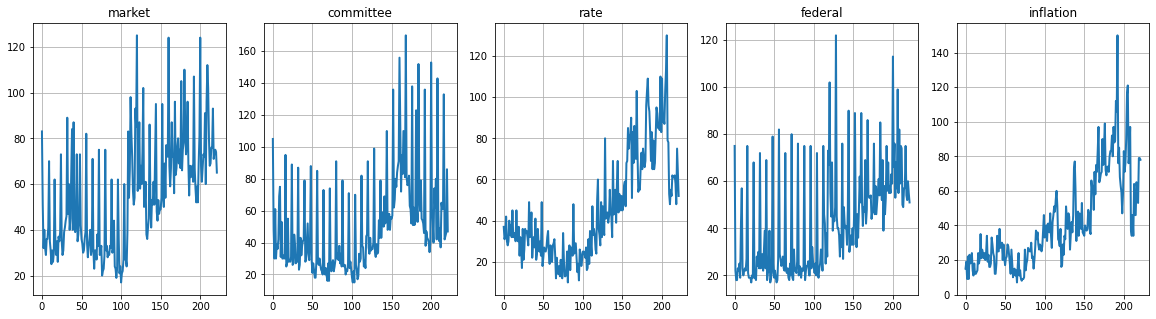

In [7]:
import matplotlib.pyplot as plt
NUM=5
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols=NUM, figsize=(20,5))
ax = (ax1, ax2, ax3, ax4, ax5)

for i in range(NUM):
  ax[i].plot(info[i:i+1].values.reshape(-1)[:-1], linewidth=2)
  ax[i].set_title(info.index.values[i])
  ax[i].grid(True)

##2.3. 政策結果毎に単語の出現頻度

>「利上げ」「維持」「利下げ」毎に議事録を分割して、それぞれの政策結果毎の単語の出現頻度をカウント

In [8]:
import numpy as np

#正規化[0,1]
def Normalization(data):
  max = np.amax(data)
  min = np.amin(data)

  nomalized = (data - min) / (max - min)

  return nomalized

#特定の日付の議事録に含まれる単語の出現率の計算
def getCount(info, date):

  #議事録ごとの単語出現頻度
  count_info = info[date]
  count_info['sum'] = count_info.sum(axis='columns')
  count_info = count_info.sort_values('sum', ascending=False)

  #単語の出現確率
  sum = count_info['sum'].sum()
  ratio = count_info['sum'].values/sum
  count_info['ratio'] = ratio


  #辞書の作成(※今回は利用しない)
  polar = {}
  normalized = Normalization(ratio)
  for i, word in enumerate(count_info.index):
    polar[word] = normalized[i]

  count_info['Norm'] = normalized

  return count_info

column_name = '当月の変化' #当月の変化or一か月前ずらし
date_stay = doc_info.loc[doc_info[column_name] == 0].index #当会合の変化：なし
date_down = doc_info.loc[doc_info[column_name] == 1].index #当会合の変化：利下げ
date_up   = doc_info.loc[doc_info[column_name] == 2].index #当会合の変化：利上げ

c_stay = getCount(info, date_stay)
c_down = getCount(info, date_down)
c_up = getCount(info, date_up)

word_ = pd.DataFrame({'info_sum': info['sum']})
word_['down_sum'] = c_down['sum'] #「利下げ」文書内の単語出現頻度
word_['stay_sum'] = c_stay['sum']
word_['up_sum'] = c_up['sum']
word_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,info_sum,down_sum,stay_sum,up_sum
market,12250.0,1564.0,8925.0,1761.0
committee,11235.0,1111.0,8512.0,1612.0
rate,10119.0,1048.0,7525.0,1546.0
federal,9318.0,1108.0,6781.0,1429.0
inflation,9239.0,801.0,6948.0,1490.0
...,...,...,...,...
spence,1.0,0.0,1.0,0.0
sup-,1.0,0.0,1.0,0.0
stock-adjustment,1.0,0.0,0.0,1.0
noncitizen,1.0,0.0,1.0,0.0


> （補足）出現頻度が300以上の単語の種類

In [9]:
len(word_['info_sum'].loc[word_['info_sum'] >300])

449

##2.4. 政策結果毎の単語の出現頻度視覚化
- 表形式
- ワードクラウド

In [10]:
#値を表・WordCloud
from wordcloud import WordCloud
import seaborn as sns; sns.set()

def make_figure(words, change='down', xlabel='pmi'):

  #Figure
  NUM = 10
  x = words[change].head(NUM).index.tolist()
  y = words[change].head(NUM).tolist()

  plt.figure(figsize=(10,5))
  plt.title(change + '-Minutes')
  plt.xlabel(xlabel)
  sns.barplot(x=y, y=x)
  #plt.savefig(f'pmi10-{change}',bbox_inches="tight")

  #WordCount
  count = {}
  for word in words.index:
    count[word] = words.loc[word,change]

  wordcloud = WordCloud(width=800,height=500, background_color='white').fit_words(count)

  plt.figure(figsize=(10,10))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.title(f'WordCloud[{change}]')
  #plt.savefig(f'WordCloud-{change}')
  plt.show()

<h2> 政策「利下げ」の議事録に含まれる単語の出現頻度

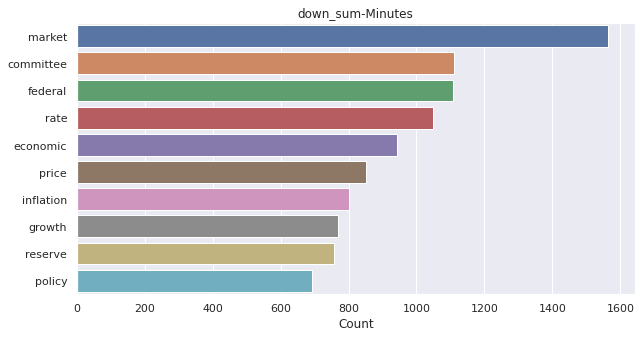

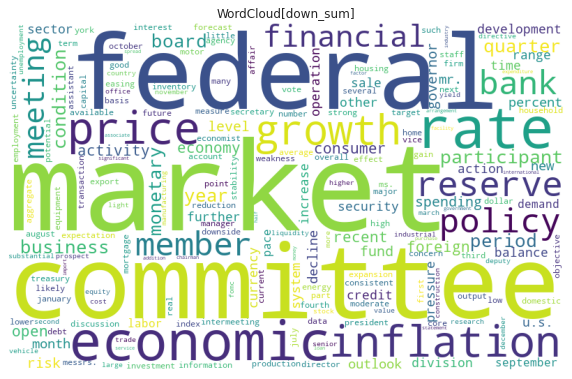

In [11]:
#上位15単語のcount値をグラフ化(down-Minutes内)
make_figure(word_.sort_values('down_sum', ascending=False), 'down_sum', 'Count')

<h2> 政策「維持」の議事録に含まれる単語の出現頻度

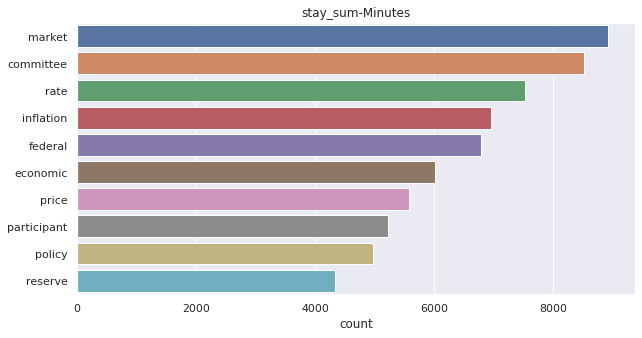

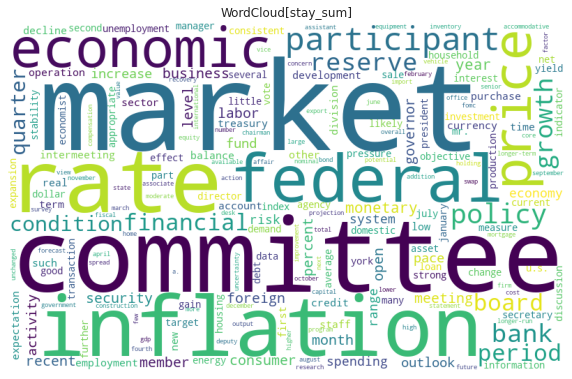

In [12]:
#上位15単語のcount値をグラフ化(stay-Minutes内)
make_figure(word_.sort_values('stay_sum', ascending=False), 'stay_sum', 'count')

<h2> 政策「利上げ」の議事録に含まれる単語の出現頻度

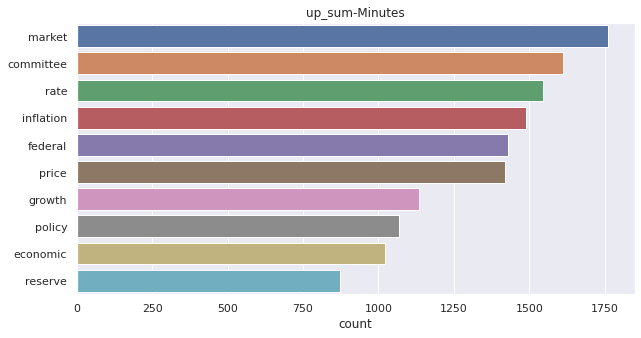

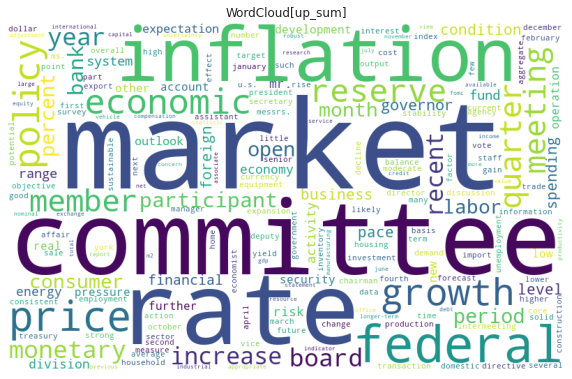

In [13]:
#上位15単語のcount値をグラフ化(up-Minutes内)
make_figure(word_.sort_values('up_sum', ascending=False), 'up_sum','count')

#3 相互情報量

$$ PMI(w,t) = \log_2 \frac{P(w,t)}{P(w)P(t)} $$
- $P(w,t)$：単語wとトピックtが同時に出現する確率
- $P(w)$：コーパス中の単語wの出現確率
- $P(t)$：議事録中のトピックtの出現確率

> [自然言語処理における自己相互情報量](https://camberbridge.github.io/2016/07/08/%E8%87%AA%E5%B7%B1%E7%9B%B8%E4%BA%92%E6%83%85%E5%A0%B1%E9%87%8F-Pointwise-Mutual-Information-PMI-%E3%81%AB%E3%81%A4%E3%81%84%E3%81%A6/)

##3.1. パラメータ

In [95]:
# パラメータ
#相互情報量を計算する際、出現頻度が極端に少ない単語を除外
COUNT = 300

#[閾値] 議事録のPMI（単語の相互情報量の平均値）を計算する際の単語のPMI閾値
DOWN_THRESHOLD = 0.5
STAY_THRESHOLD = 0.5
UP_THRESHOLD = 0.5

#[個数] 議事録のPMI（単語の相互情報量の平均値）を計算する際、上位何単語を利用するか
DOWN_COUNT = 100
STAY_COUNT = 100
UP_COUNT = 100

# 議事録のPMI（単語の相互情報量の平均値）を計算する際に使用する単語の選定方法
verbose = False #True:閾値、False：個数

##3.2. 相互情報量の計算

In [141]:
#相互情報量の計算を行う関数
def ppmi(down_date, stay_date, up_date, word_matrix, eps=1e-8):

  # P(t)の計算
  document_size = len(down_date) + len(stay_date) + len(up_date)
  P_down = len(down_date) / document_size
  P_stay = len(stay_date) / document_size
  P_up = len(up_date) / document_size
  P_change = [P_down, P_stay, P_up] # P(t)

  word_size = np.sum(word_matrix)

  #PMIを格納するフレーム(size([単語数, トピック数]))
  M = np.zeros_like(word_matrix, dtype=np.float32)

  for i in range(word_matrix.shape[0]):
    for j in range(word_matrix.shape[1]):
      p_w = np.sum(word_matrix[i]) / word_size # P(w=word)
      p_d = P_change[j] # P(t=change)
      p_w_d = word_matrix[i, j] / word_size # P(w=word, t=change)

      #相互情報量
      pmi = np.log2(p_w_d / (p_w*p_d+eps) + eps) # log2(P(w,t)/P(w)P(t))
      M[i, j] = pmi

  return M

#相互情報量を計算する際、出現頻度が極端に少ない単語を除外
COUNT = COUNT
word_tmp = word_.loc[word_['info_sum'] > COUNT]
word_matrix = word_tmp.loc[:,['down_sum', 'stay_sum','up_sum']].values

#各単語-各トピックpmi結果
np.set_printoptions(precision=3)
W = ppmi(date_down, date_stay, date_up, word_matrix)
pd.set_option('display.max_rows', 10)
word_ppmi = pd.DataFrame(W, index=word_tmp.index, columns=['down', 'stay', 'up'])

#各ppim値でソート
word_down = word_ppmi.sort_values('down', ascending=False) #downの値でソート
word_stay = word_ppmi.sort_values('stay', ascending=False) #stayの値でソート
word_up = word_ppmi.sort_values('up', ascending=False) #upの値でソート

word_ppmi

,down,stay,up
market,0.124501,0.042937,-0.289305
committee,-0.244099,0.099364,-0.292067
rate,-0.177387,0.072491,-0.201445
federal,0.021906,0.041272,-0.196006
inflation,-0.433894,0.088655,-0.123416
...,...,...,...
long-term,-0.408749,0.094119,-0.163561
single-family,-0.029632,0.047992,-0.189213
outcome,0.093750,0.134473,-0.832174
implementation,0.605463,-0.015496,-0.524858


##3.3. PMIの極性の視覚化

<h2> 政策「利下げ」に対する極性が強い単語


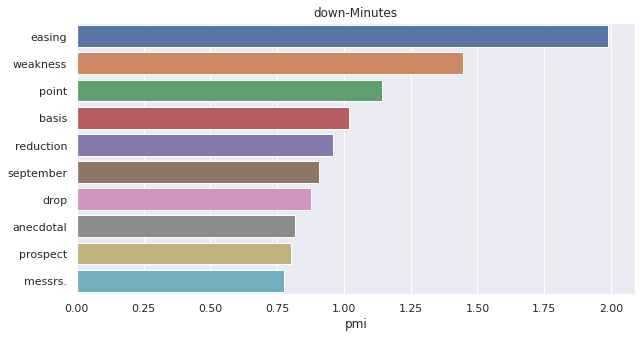

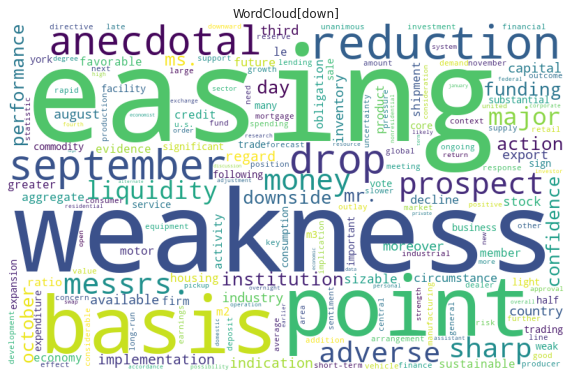

In [100]:
#上位15単語のpim値をグラフ化(利下げ)
make_figure(word_down, 'down')

<h2> 政策「利下げ」に対する極性が強い単語

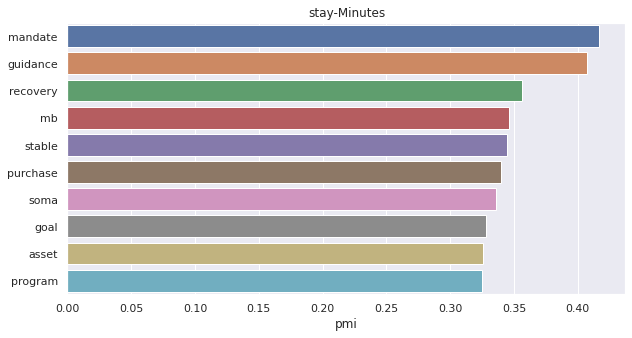

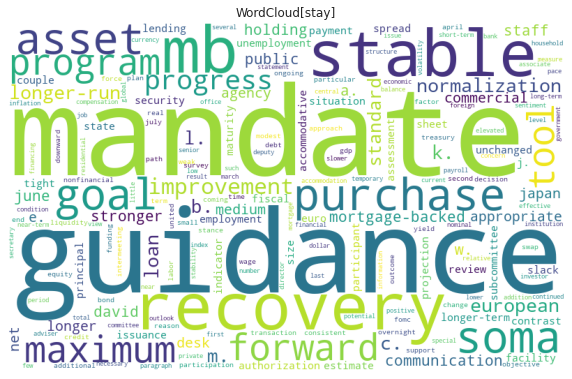

In [101]:
#上位15単語のpim値をグラフ化(維持)
make_figure(word_stay, 'stay')

<h2> 政策「利下げ」に対する極性が強い単語

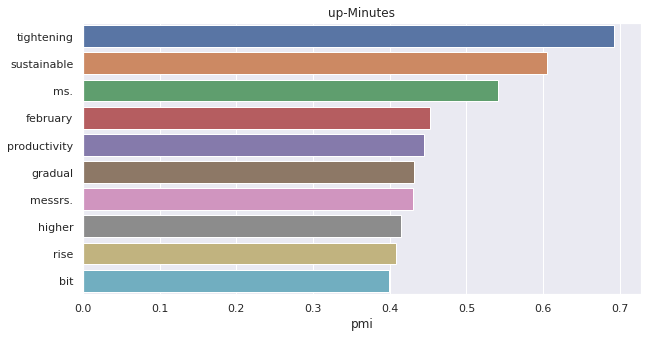

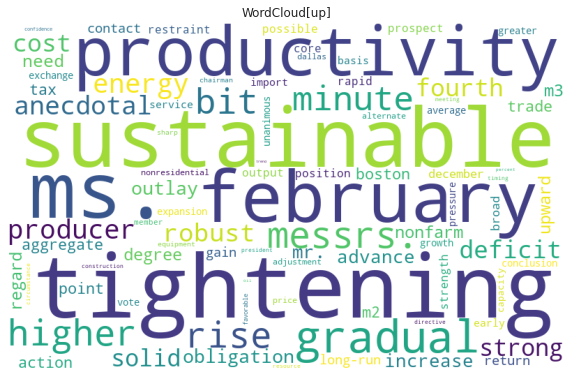

In [104]:
#上位15単語のpim値をグラフ化(利上げ)
make_figure(word_up, 'up')

##3.4. 指定した単語の出現頻度の推移

In [107]:
# 特定の単語の出現頻度をグラフ化する関数
def count_graph(word='market', width=15, height=2, labels='L&H'):
    fig, ax = plt.subplots(figsize=(width,height))
    ax.plot(info.loc[word,:][:-1].values)

    #利下げ時期を視覚化
    def Lower():
            
        label = 'Lower'
        for date in date_down:
            x = info.columns.tolist().index(date)
            ax.axvspan(x-0.5, x+0.5, color = "lightblue", label=label)
            label=None
        
    #利上げ時期を視覚化
    def Higher():

        label = 'Higher'
        for date in date_up:
            x = info.columns.tolist().index(date)
            ax.axvspan(x-0.5, x+0.5, color = "salmon", label=label, alpha=0.5)
            label=None

    #ラベルを指定
    if labels=='L':
        Lower()
    elif labels=='H':
        Higher()
    elif labels=='L&H':
        Lower()
        Higher()

    #グラフの体裁
    x = np.arange(0,len(info.columns.tolist()[:-1]), 8)
    plt.xticks(x, info.columns[x], rotation=45)
    plt.title(f'[{word}] : {word_.loc[word, "info_sum"]} times in Minutes')
    plt.ylabel('Count')
    ax.legend()
    #plt.savefig(f'up_{word}.png',bbox_inches="tight")

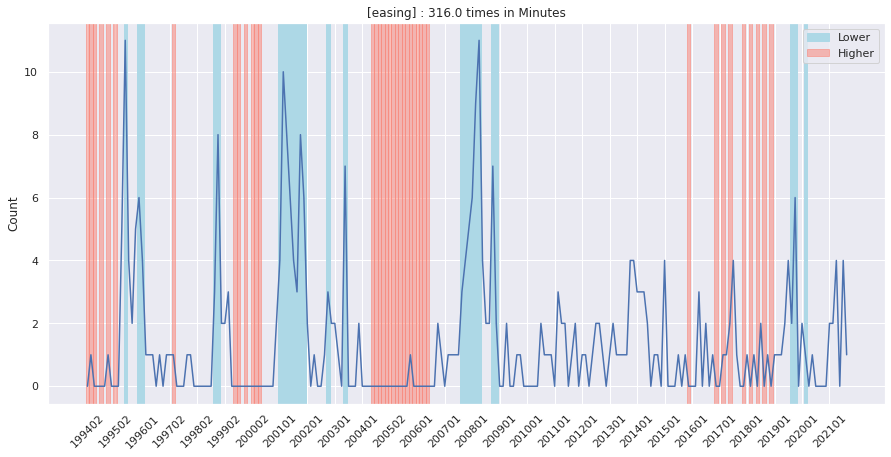

In [136]:
count_graph('easing', 15, 7, 'L&H')

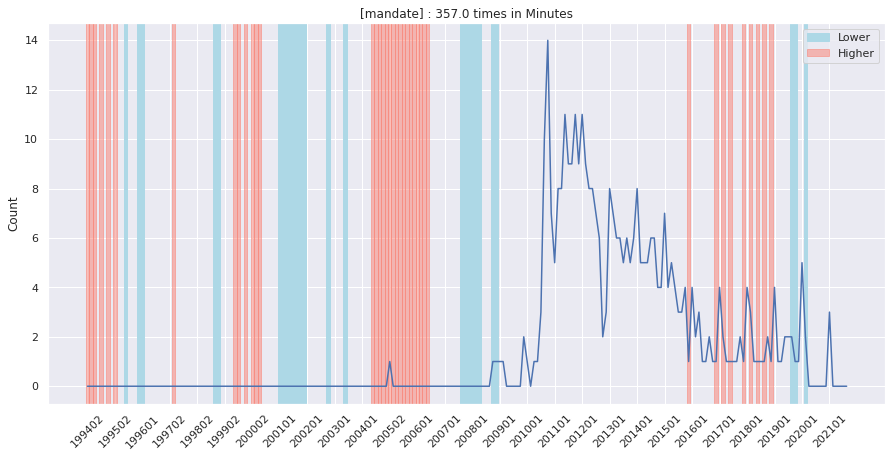

In [109]:
count_graph('mandate', 15, 7,)

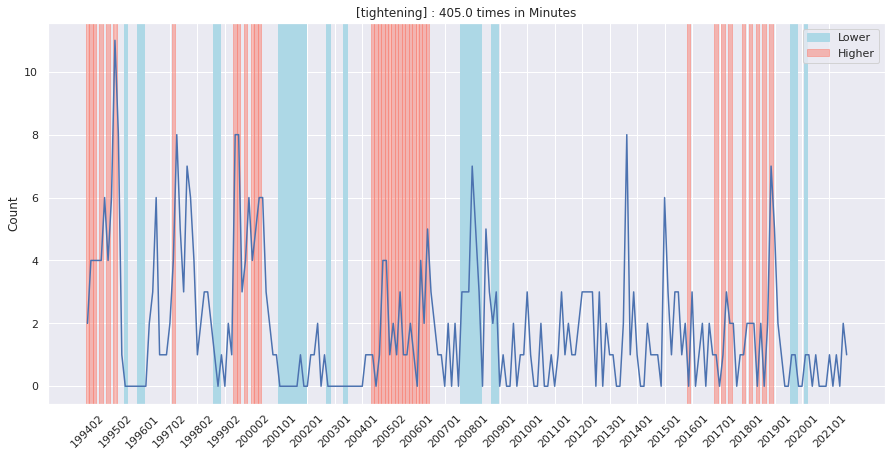

In [110]:
count_graph('tightening', 15, 7, 'L&H')

#4. 文書ベクトル

文書ベクトル＝文書に含まれる単語のPMI値の平均値

$$ D_t = \frac{1}{N} \sum_{s=1}^{S=N} PMI(w_s, t) $$

$$ t \in \{raise, hold, lower \}$$

※正のPMIを持つ単語のみ使用


In [138]:
#pmiの閾値を設定する関数
def ppmi_threshold(word_change, change, threshold, count, verbose=True):
    tmp = word_change[change]
    tmp = tmp.loc[tmp > 0] #負のpmiは利用しない
    if verbose:
        word_down_head = tmp.loc[tmp > threshold] #threshold
    else:
        word_down_head = tmp.head(count)
    return word_down_head

#閾値で設定した値以上のpmiを持つ単語を取り出す（ソート済み）
verbose = False #True:閾値、False：個数
down_threshold = ppmi_threshold(word_down, 'down', 0.5, 100, verbose)
stay_threshold = ppmi_threshold(word_stay, 'stay', 0.5, 100, verbose)
up_threshold = ppmi_threshold(word_up, 'up', 0.5, 100, verbose)


#議事録のpmi（議事録内の単語の平均pmi値）を計算する関数
def doc_pmi(threshold_pmi):
    doc_change_pmi = []
    for date in info.columns.tolist()[:-1]:
        value = 0
        for i, word in enumerate(threshold_pmi.index):
            value += threshold_pmi[word] * info.loc[word,date]
        
        sum = info[date].sum()
        doc_change_pmi.append(value/sum)
        #doc_change_pmi.append(value)
    return doc_change_pmi

# 議事録のpmi計算
doc_down_pmi = doc_pmi(down_threshold)
doc_stay_pmi = doc_pmi(stay_threshold)
doc_up_pmi = doc_pmi(up_threshold)

#議事録のpmiを保存
doc_pmi = pd.DataFrame({'Lower':doc_down_pmi,
              'Hold':doc_stay_pmi,
              'Raise':doc_stay_pmi},
             index=info.columns[:-1]) 
doc_pmi.to_pickle('doc_pmi.pkl')

doc_pmi

,Lower,Hold,Raise
199402,0.055678,0.011895,0.011895
199403,0.075239,0.008851,0.008851
199405,0.068422,0.008805,0.008805
199407,0.068079,0.008445,0.008445
199408,0.067912,0.007799,0.007799
...,...,...,...
202103,0.035144,0.035859,0.035859
202104,0.042046,0.035811,0.035811
202106,0.035447,0.038109,0.038109
202107,0.038753,0.046756,0.046756


##4.1 文書ベクトルの推移

政策「利下げ」の極性
政策「維持」の極性
政策「利上げ」の極性


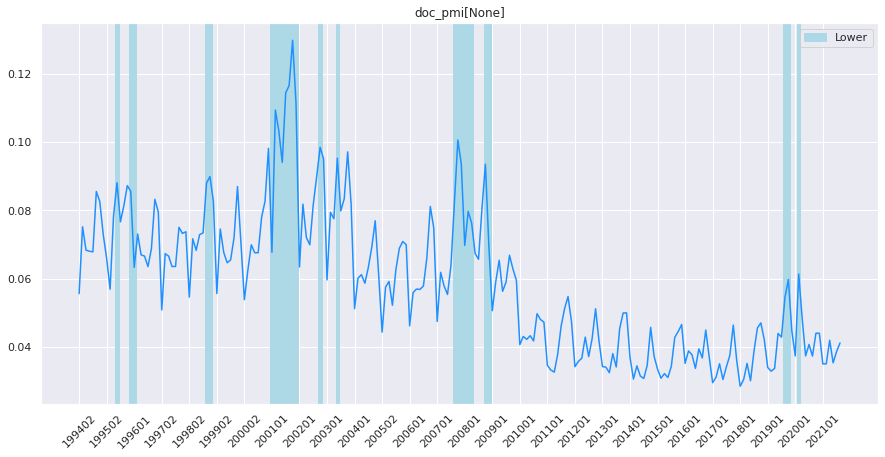

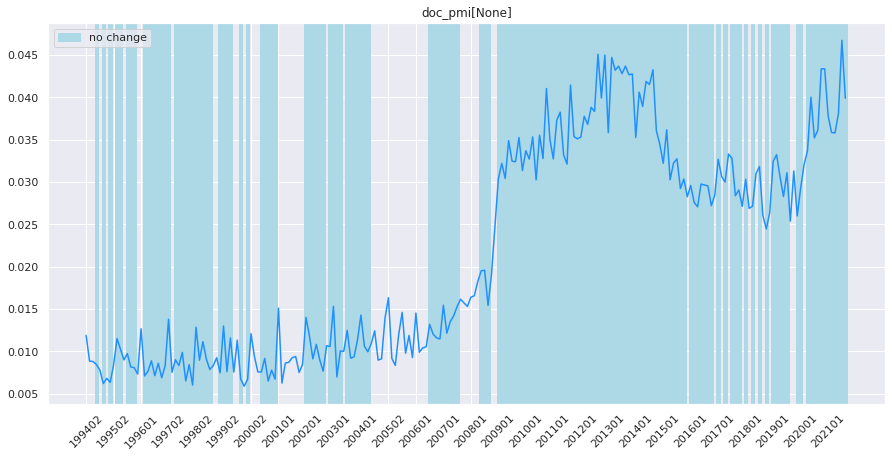

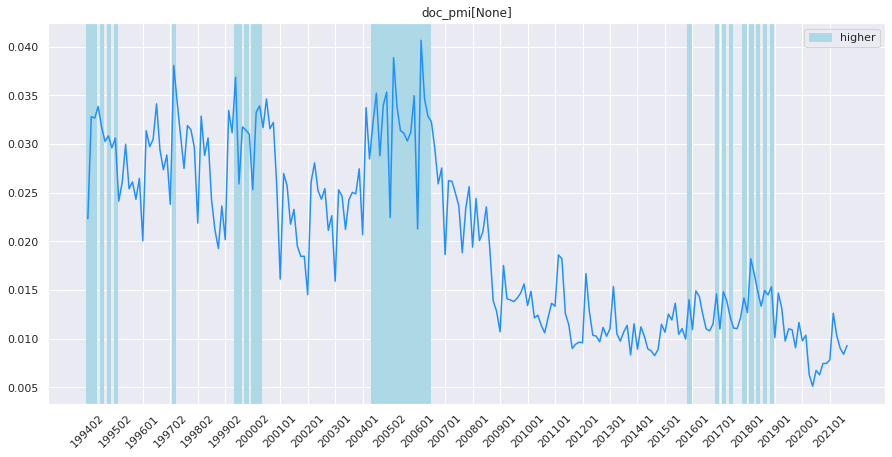

In [142]:
#議事録のpmi値と政策変更結果の関係を出力する関数
def make_ppmiFigure(seq ,date_change=date_down, label='Lower', color='dodgerblue', spcolor="lightblue"):
    fig, ax = plt.subplots(figsize=(15,7))
    ax.plot(seq, color=color)
    label_save = label
    for date in date_change:
        x = info.columns.tolist().index(date)
        ax.axvspan(x-0.5, x+0.5, color = spcolor, label=label)
        label=None
    x = np.arange(0,len(info.columns.tolist()[:-1]), 8)
    plt.xticks(x, info.columns[x], rotation=45)
    ax.legend()
    ax.set_title(f'doc_pmi[{label}]')
    #fig.savefig(f'doc_pmi-{label_save}.png')
    fig.show()

print('政策「利下げ」の極性')
make_ppmiFigure(doc_down_pmi)
print('政策「維持」の極性')
make_ppmiFigure(doc_stay_pmi, date_stay, 'no change')
print('政策「利上げ」の極性')
make_ppmiFigure(doc_up_pmi, date_up, 'higher')

##4.2. カーネル密度推定

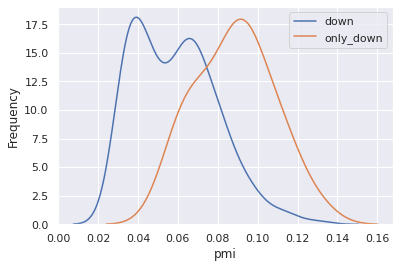

In [123]:
import seaborn

#密度関数,分布
p = seaborn.kdeplot(doc_down_pmi, label='down')

d_index = [info.columns.tolist().index(date) for date in date_down]
only_down_pmi = [doc_down_pmi[i] for i in d_index]
seaborn.kdeplot(only_down_pmi, label='only_down')
p.legend()
p.set_xlabel('pmi')
p.set_ylabel('Frequency')
plt.savefig('down.png')

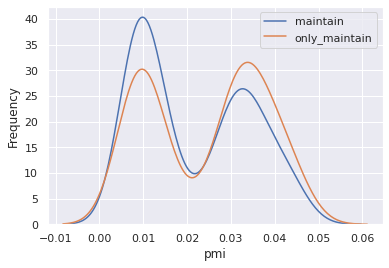

In [124]:
p = seaborn.kdeplot(doc_stay_pmi, label='maintain')
s_index = [info.columns.tolist().index(date) for date in date_stay]
only_stay_pmi = [doc_stay_pmi[i] for i in s_index]
seaborn.kdeplot(only_stay_pmi, label='only_maintain')
p.legend()
p.set_xlabel('pmi')
p.set_ylabel('Frequency')
plt.savefig('maintain.png')

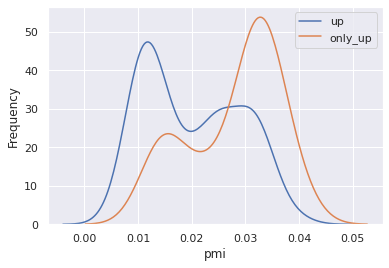

In [125]:
p = seaborn.kdeplot(doc_up_pmi, label='up')
s_index = [info.columns.tolist().index(date) for date in date_up]
only_up_pmi = [doc_up_pmi[i] for i in s_index]
seaborn.kdeplot(only_up_pmi, label='only_up')
p.legend()
p.set_xlabel('pmi')
p.set_ylabel('Frequency')
plt.savefig('up.png')